In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as f
from pyspark.sql.functions import col, mean
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, NaiveBayes 
from pyspark.ml.feature import HashingTF, Tokenizer, VectorAssembler, MinMaxScaler, StringIndexer, PCA
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, ClusteringEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.clustering import KMeans, BisectingKMeans
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def plot_cv_results(model_name, cvModel):
    paramMaps = paramGrids[model_name]
    avgMetrics = cvModel.avgMetrics
    
    if model_name == "Logistic Regression":
        regParams = [paramMap[models[model_name].regParam] for paramMap in paramMaps]
        elasticNetParams = [paramMap[models[model_name].elasticNetParam] for paramMap in paramMaps]
        param1, param2 = "параметр регуляризации", "параметр elasticNet"
        param1_vals, param2_vals = regParams, elasticNetParams
    elif model_name == "Decision Tree":
        depths = [paramMap[models[model_name].maxDepth] for paramMap in paramMaps]
        bins = [paramMap[models[model_name].maxBins] for paramMap in paramMaps]
        param1, param2 = "макс. глубина", "макс. кол-во ячеек"
        param1_vals, param2_vals = depths, bins
    elif model_name == "Random Forest":
        trees = [paramMap[models[model_name].numTrees] for paramMap in paramMaps]
        depths = [paramMap[models[model_name].maxDepth] for paramMap in paramMaps]
        param1, param2 = "кол-во деревьев", "макс. глубина"
        param1_vals, param2_vals = trees, depths
    elif model_name == "Naive Bayes":
        smoothing = [paramMap[models[model_name].smoothing] for paramMap in paramMaps]
        param1, param2 = "сглаживание", None
        param1_vals, param2_vals = smoothing, None

    fig, ax = plt.subplots()
    if param2 is not None:
        scatter = ax.scatter(param1_vals, param2_vals, c=avgMetrics, cmap='viridis')
        ax.set_xlabel(param1)
        ax.set_ylabel(param2)
    else:
        scatter = ax.scatter(param1_vals, [0]*len(param1_vals), c=avgMetrics, cmap='viridis')
        ax.set_xlabel(param1)

    ax.set_title(f"Результаты перекрестного валидирования для {model_name}")
    colorbar = fig.colorbar(scatter)
    colorbar.set_label('Точность')
    plt.show()

In [3]:
# Создание Spark сессии
spark = SparkSession.builder.appName("Crop_Recommendation").getOrCreate()
data = spark.read.csv("Crop_Recommendation.csv", header="True")
dataPD = pd.read_csv("Crop_Recommendation.csv")

# Переименование столбцов
data = data.withColumnRenamed("Nitrogen", "Азот") \
           .withColumnRenamed("Phosphorus", "Фосфор") \
           .withColumnRenamed("Potassium", "Калий") \
           .withColumnRenamed("Temperature", "Температура") \
           .withColumnRenamed("Humidity", "Влажность") \
           .withColumnRenamed("pH_Value", "Значение pH") \
           .withColumnRenamed("Rainfall", "Осадки") \
           .withColumnRenamed("Crop", "Kультура")

data.printSchema()
data.show(5)

# Вывод минимальных и максимальных значений каждого числового столбца
data.describe()\
  .select('summary', *[f.round(c, 2).alias(c) for c in data.columns[:-1]])\
  .show()
    
# Вывод уникальных значений типов культур
culture_types = data.select("Kультура").distinct().rdd.flatMap(lambda x: x).collect()
print("Уникальные культуры:")
print(culture_types)

2024-06-18 01:21:55,601 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


root
 |-- Азот: string (nullable = true)
 |-- Фосфор: string (nullable = true)
 |-- Калий: string (nullable = true)
 |-- Температура: string (nullable = true)
 |-- Влажность: string (nullable = true)
 |-- Значение pH: string (nullable = true)
 |-- Осадки: string (nullable = true)
 |-- Kультура: string (nullable = true)

+----+------+-----+-----------+-----------+-----------+-----------+--------+
|Азот|Фосфор|Калий|Температура|  Влажность|Значение pH|     Осадки|Kультура|
+----+------+-----+-----------+-----------+-----------+-----------+--------+
|  90|    42|   43|20.87974371|82.00274423|6.502985292|202.9355362|    Rice|
|  85|    58|   41|21.77046169|80.31964408|7.038096361|226.6555374|    Rice|
|  60|    55|   44|23.00445915| 82.3207629|7.840207144|263.9642476|    Rice|
|  74|    35|   40|26.49109635|80.15836264|6.980400905|242.8640342|    Rice|
|  78|    42|   42|20.13017482|81.60487287|7.628472891|262.7173405|    Rice|
+----+------+-----+-----------+-----------+-----------+-------

+-------+------+------+------+-----------+---------+-----------+------+
|summary|  Азот|Фосфор| Калий|Температура|Влажность|Значение pH|Осадки|
+-------+------+------+------+-----------+---------+-----------+------+
|  count|2200.0|2200.0|2200.0|     2200.0|   2200.0|     2200.0|2200.0|
|   mean| 50.55| 53.36| 48.15|      25.62|    71.48|       6.47|103.46|
| stddev| 36.92| 32.99| 50.65|       5.06|    22.26|       0.77| 54.96|
|    min|   0.0|  10.0|  10.0|      10.01|    14.26|        3.5|100.01|
|    max|  99.0|  95.0|   9.0|       9.95|    99.98|       9.94| 99.98|
+-------+------+------+------+-----------+---------+-----------+------+



Уникальные культуры:
['Papaya', 'PigeonPeas', 'Orange', 'ChickPea', 'Banana', 'Maize', 'Muskmelon', 'Coconut', 'MothBeans', 'Blackgram', 'KidneyBeans', 'Grapes', 'Jute', 'Coffee', 'Mango', 'Cotton', 'Rice', 'Watermelon', 'MungBean', 'Pomegranate', 'Apple', 'Lentil']


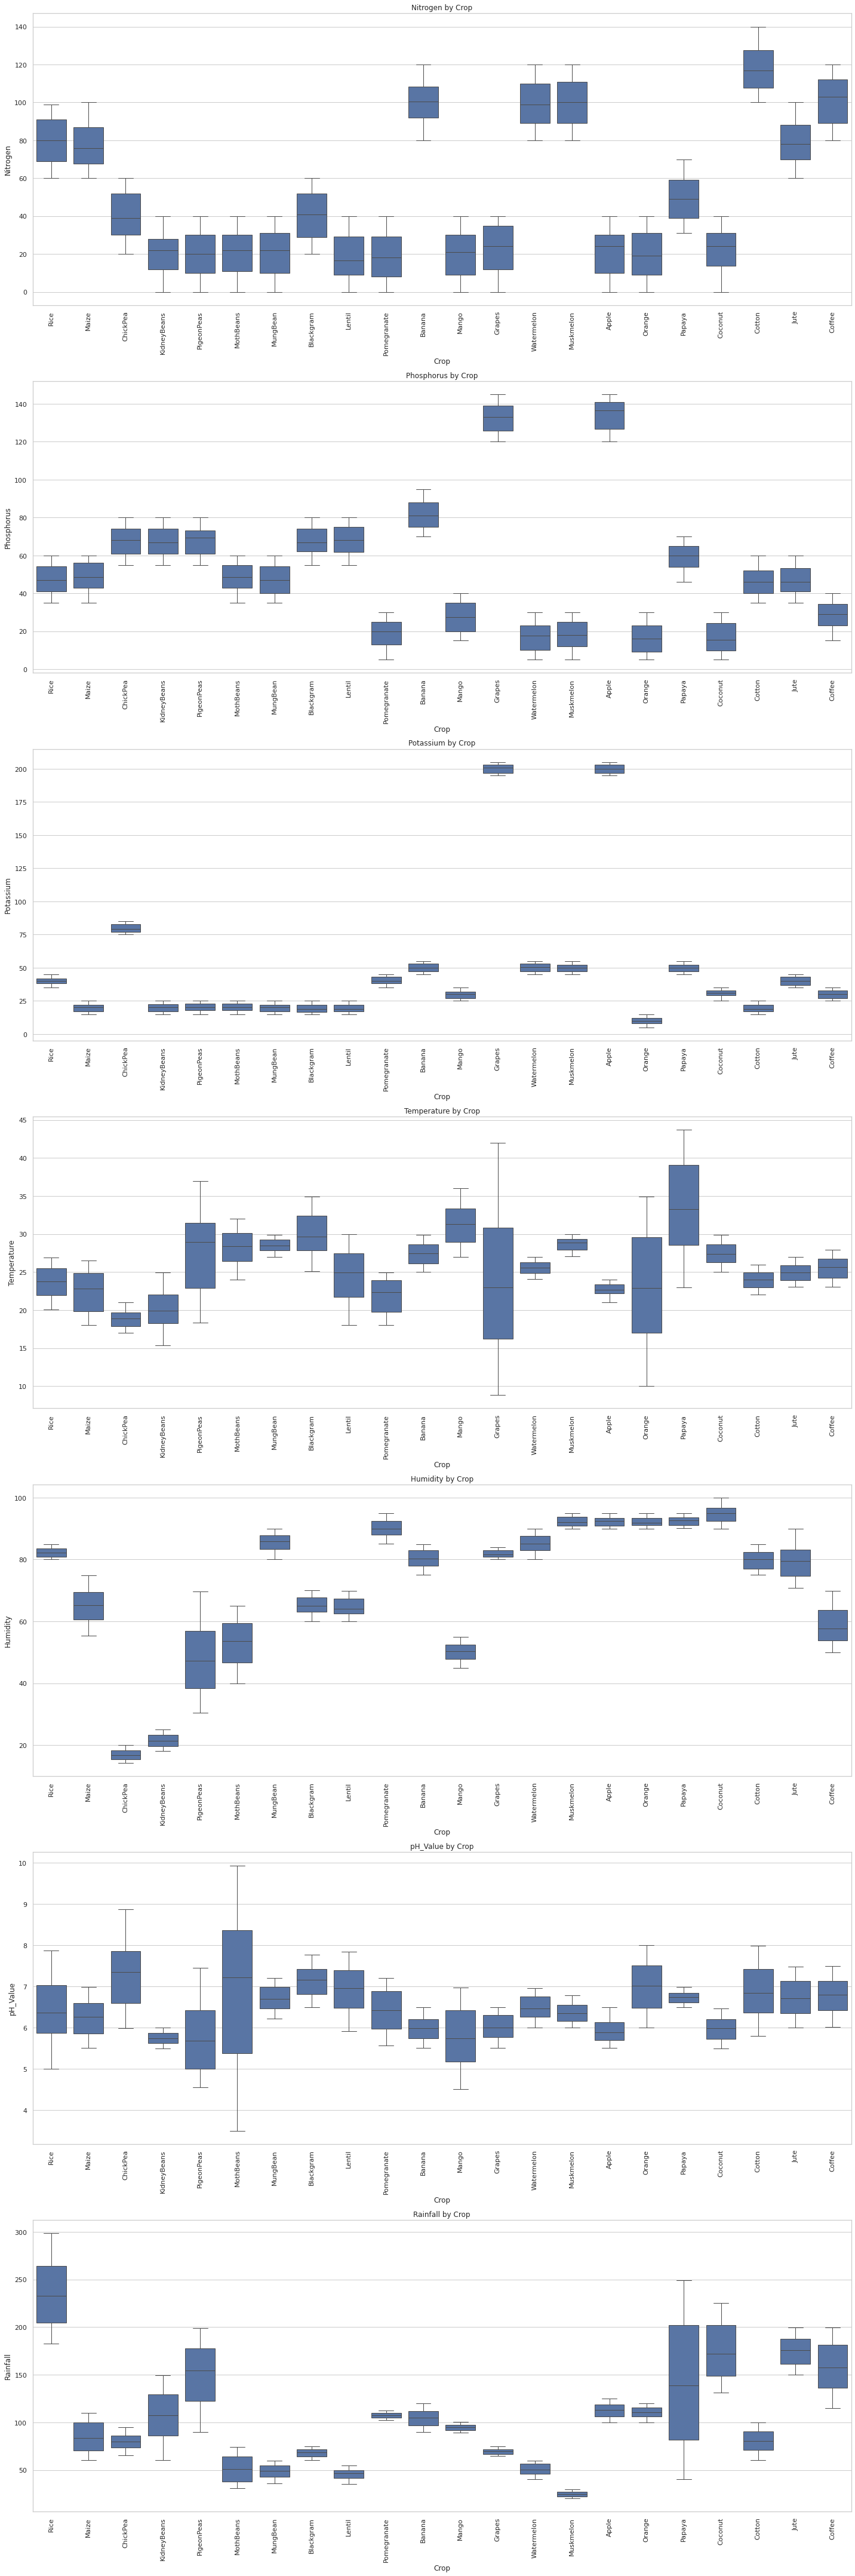

In [4]:
pltColumns = ['Nitrogen', 'Phosphorus', 'Potassium', 'Temperature', 'Humidity', 'pH_Value', 'Rainfall']

sns.set(style="whitegrid")

# Построение ящиков с усами для каждого числового признака
plt.figure(figsize=(20, 60))

for i, feature in enumerate(pltColumns, 1):
    plt.subplot(7, 1, i)
    sns.boxplot(x='Crop', y=feature, data=dataPD)
    plt.xticks(rotation=90)
    plt.title(f'{feature} by Crop')
    
plt.tight_layout()
plt.show()

In [5]:
# Преобразование столбцов в float и заполнение пропусков
for col_name in data.columns[:-1]:
    data = data.withColumn(col_name, col(col_name).cast("float"))
    avg_value = data.select(mean(col(col_name))).collect()[0][0]
    data = data.na.fill({col_name: avg_value})
    
# Векторизация данных
assembler = VectorAssembler(inputCols=data.columns[:-1], outputCol="features")
data = assembler.transform(data)

# Нормализация данных с использованием MinMaxScaler
scaler = MinMaxScaler(inputCol="features", outputCol="scaledFeatures", min=0, max=10)
scalerModel = scaler.fit(data)
data = scalerModel.transform(data)

# Удаление столбца 'label', если он уже существует
if 'label' in data.columns:
    data = data.drop('label')
    
# Преобразование категориального столбца в числовой
indexer = StringIndexer(inputCol="Kультура", outputCol="label")
data = indexer.fit(data).transform(data)

# Проверка результата
data.printSchema()
data.show(5)

root
 |-- Азот: float (nullable = false)
 |-- Фосфор: float (nullable = false)
 |-- Калий: float (nullable = false)
 |-- Температура: float (nullable = false)
 |-- Влажность: float (nullable = false)
 |-- Значение pH: float (nullable = false)
 |-- Осадки: float (nullable = false)
 |-- Kультура: string (nullable = true)
 |-- features: vector (nullable = true)
 |-- scaledFeatures: vector (nullable = true)
 |-- label: double (nullable = false)

+----+------+-----+-----------+---------+-----------+---------+--------+--------------------+--------------------+-----+
|Азот|Фосфор|Калий|Температура|Влажность|Значение pH|   Осадки|Kультура|            features|      scaledFeatures|label|
+----+------+-----+-----------+---------+-----------+---------+--------+--------------------+--------------------+-----+
|90.0|  42.0| 43.0|  20.879744| 82.00275|  6.5029855|202.93553|    Rice|[90.0,42.0,43.0,2...|[6.42857142857142...| 20.0|
|85.0|  58.0| 41.0|  21.770462| 80.31964|  7.0380964|226.65553|    Ric

In [6]:
# Разделение данных на обучающую и тестовую выборки
train_data, test_data = data.randomSplit([0.8, 0.2])

models = {
    "Logistic Regression": LogisticRegression(labelCol="label", featuresCol="scaledFeatures"),
    "Decision Tree": DecisionTreeClassifier(labelCol="label", featuresCol="scaledFeatures"),
    "Random Forest": RandomForestClassifier(labelCol="label", featuresCol="scaledFeatures"),
    "Naive Bayes": NaiveBayes(labelCol="label", featuresCol="scaledFeatures")
}

# Создание сеток гиперпараметров
paramGrids = {
    "Logistic Regression": (ParamGridBuilder()
                            .addGrid(models["Logistic Regression"].regParam, [0.01, 0.1, 1.0])
                            .addGrid(models["Logistic Regression"].elasticNetParam, [0.0, 0.5, 1.0])
                            .build()),
    "Decision Tree": (ParamGridBuilder()
                      .addGrid(models["Decision Tree"].maxDepth, [5, 10, 15])
                      .addGrid(models["Decision Tree"].maxBins, [32, 40, 50])
                      .build()),
    "Random Forest": (ParamGridBuilder()
                      .addGrid(models["Random Forest"].numTrees, [10, 20])
                      .addGrid(models["Random Forest"].maxDepth, [5, 10])
                      .build()),
    "Naive Bayes": (ParamGridBuilder()
                    .addGrid(models["Naive Bayes"].smoothing, [0.5, 1.0, 1.5])
                    .build())
}

# Создание оценщика
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")

2024-06-18 01:22:20,226 WARN netlib.BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
2024-06-18 01:22:20,227 WARN netlib.BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


Точность Logistic Regression: 0.9248


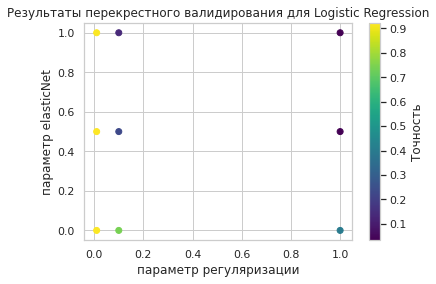

Точность Decision Tree: 0.9956


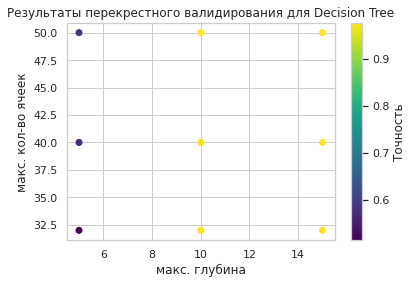

Точность Random Forest: 0.9867


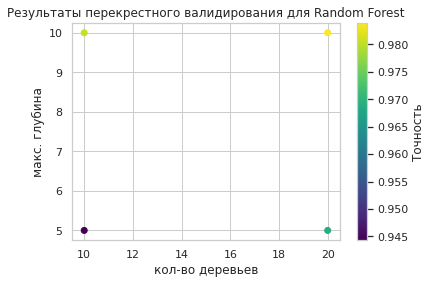

Точность Naive Bayes: 0.8850


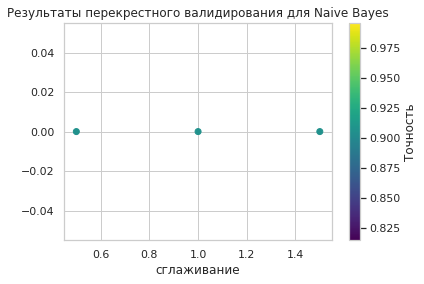


Лучшая модель: Decision Tree с точностью: 0.9956
Лучшие параметры: макс. глубина=10, макс. кол-во ячеек=50


In [7]:
# Кросс-валидация и оценка всех моделей
results = {}

for model_name, model in models.items():
    paramGrid = paramGrids[model_name]
    cv = CrossValidator(estimator=model, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)
    cvModel = cv.fit(train_data)
    predictions = cvModel.transform(test_data)
    accuracy = evaluator.evaluate(predictions)
    results[model_name] = (accuracy, cvModel)
    print(f"Точность {model_name}: {accuracy:.4f}")
    
    # Визуализация результатов кросс-валидации
    plot_cv_results(model_name, cvModel)

# Поиск лучшей модели
best_model_name, (best_accuracy, best_cvModel) = max(results.items(), key=lambda item: item[1][0])

print(f"\nЛучшая модель: {best_model_name} с точностью: {best_accuracy:.4f}")

# Вывод лучших гиперпараметров для лучшей модели
bestModel = best_cvModel.bestModel
bestParams = bestModel.extractParamMap()

paramStr = ""
if best_model_name == "Logistic Regression":
    paramStr = f"Лучшие параметры: параметр регуляризации={bestParams[models['Logistic Regression'].regParam]}, параметр elasticNet={bestParams[models['Logistic Regression'].elasticNetParam]}"
elif best_model_name == "Decision Tree":
    paramStr = f"Лучшие параметры: макс. глубина={bestParams[models['Decision Tree'].maxDepth]}, макс. кол-во ячеек={bestParams[models['Decision Tree'].maxBins]}"
elif best_model_name == "Random Forest":
    paramStr = f"Лучшие параметры: кол-во деревьев={bestParams[models['Random Forest'].numTrees]}, макс. глубина={bestParams[models['Random Forest'].maxDepth]}"
elif best_model_name == "Naive Bayes":
    paramStr = f"Лучшие параметры: сглаживание={bestParams[models['Naive Bayes'].smoothing]}"

print(paramStr)

Text(0, 0.5, 'Силуэтный балл')

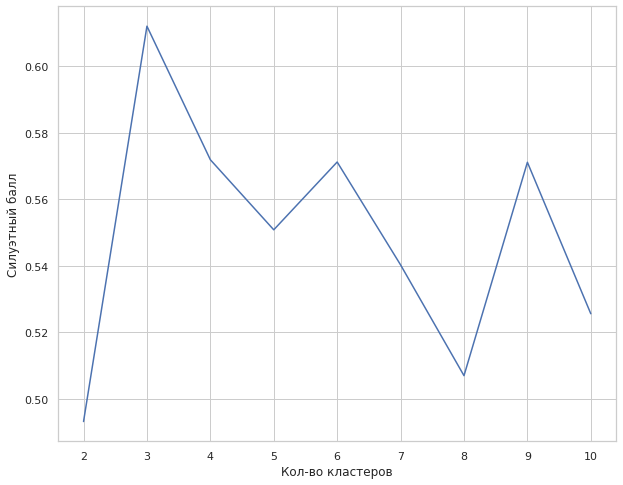

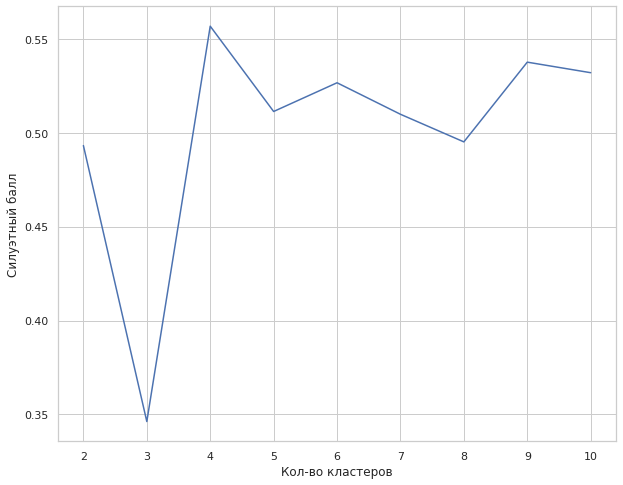

In [8]:
evaluator = ClusteringEvaluator(featuresCol='features', \
metricName='silhouette', distanceMeasure='squaredEuclidean') # помимо выбранной Евклидовой меры расстояния доступна ещё косинусная близость distanceMeasure='cosine', но мы в дальнейшем будем запускать метод K-Means, а он использует Евклидово расстояние в качестве меры расстояния

silhouette_scores = []

for K in range(2,11):
    KMeans_ = KMeans(featuresCol='features', k=K)
    #KMeans_ = BisectingKMeans (featuresCol='features', k=K) # для модифицированного K-means
    KMeans_fit = KMeans_.fit(data)
    KMeans_transform = KMeans_fit.transform(data)
    evaluation_score = evaluator.evaluate(KMeans_transform)
    silhouette_scores.append(evaluation_score)    

fig, ax = plt.subplots(1,1, figsize =(10,8))
ax.plot(range(2,11),silhouette_scores)
ax.set_xlabel('Кол-во кластеров')
ax.set_ylabel('Силуэтный балл')

silhouette_scores = []

for K in range(2,11):
    #KMeans_ = KMeans(featuresCol='features', k=K)
    KMeans_ = BisectingKMeans (featuresCol='features', k=K) # для модифицированного K-means
    KMeans_fit = KMeans_.fit(data)
    KMeans_transform = KMeans_fit.transform(data)
    evaluation_score = evaluator.evaluate(KMeans_transform)
    silhouette_scores.append(evaluation_score)    

fig, ax = plt.subplots(1,1, figsize =(10,8))
ax.plot(range(2,11),silhouette_scores)
ax.set_xlabel('Кол-во кластеров')
ax.set_ylabel('Силуэтный балл')

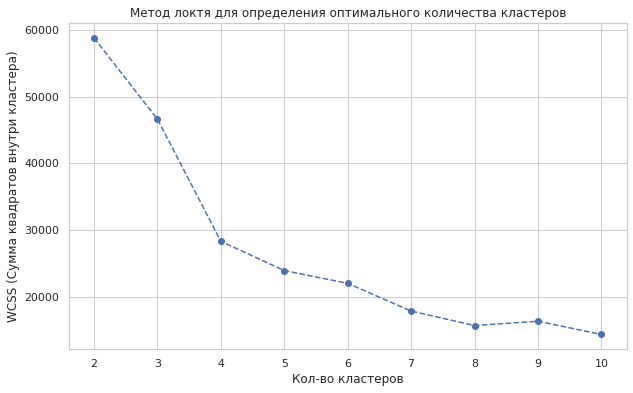

2024-06-18 01:26:43,017 WARN netlib.LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeSystemLAPACK
2024-06-18 01:26:43,019 WARN netlib.LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeRefLAPACK


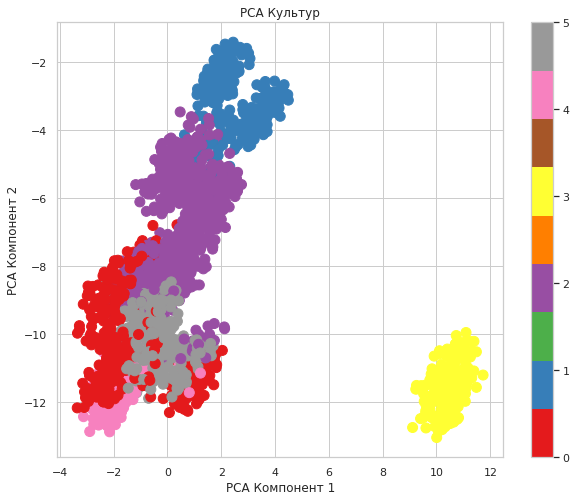

+-------+------------------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+---------------+------------+
|Cluster|         avg(Азот)|       avg(Фосфор)|        avg(Калий)|  avg(Температура)|    avg(Влажность)| avg(Значение pH)|       avg(Осадки)|        avg(label)|avg(prediction)|avg(Cluster)|
+-------+------------------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+---------------+------------+
|      1| 27.96268656716418| 67.24253731343283|42.582089552238806|21.379750369200067|24.850412657011802|6.318091386289739|106.70588713973316| 8.932835820895523|            1.0|         1.0|
|      3|             21.99|           133.375|             200.0|23.240258736610414|  87.1043053817749|5.977799801826477|  91.1333039855957|               3.5|            3.0|         3.0|
|      5| 56.71597633136095|41.405325443786985| 38

In [9]:
# Определение количества кластеров с использованием метода локтя
wcss = []
for K in range(2, 11):
    kmeans = KMeans(featuresCol='scaledFeatures', k=K)
    model = kmeans.fit(data)
    wcss.append(model.summary.trainingCost)

# Визуализация метода локтя
plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), wcss, marker='o', linestyle='--')
plt.title('Метод локтя для определения оптимального количества кластеров')
plt.xlabel('Кол-во кластеров')
plt.ylabel('WCSS (Сумма квадратов внутри кластера)')
plt.show()

# Оптимальное количество кластеров (предположим 4)
n_clusters = 6
kmeans = KMeans(featuresCol='scaledFeatures', k=n_clusters)
kmeans_model = kmeans.fit(data)
kmeans_assignments = kmeans_model.transform(data)

# Добавление меток кластеров к датасету
data = kmeans_assignments.withColumn("Cluster", col("prediction"))

# PCA для уменьшения размерности
pca = PCA(k=2, inputCol="scaledFeatures", outputCol="pcaFeatures")
pca_model = pca.fit(data)
data = pca_model.transform(data)

# Извлечение данных для визуализации
pca_features = data.select("pcaFeatures").collect()
clusters = data.select("Cluster").collect()

# Преобразование данных для визуализации
pca_features = [row[0] for row in pca_features]
pca_x = [features[0] for features in pca_features]
pca_y = [features[1] for features in pca_features]
clusters = [row[0] for row in clusters]

# Визуализация кластеров с использованием PCA
plt.figure(figsize=(10, 8))
plt.scatter(pca_x, pca_y, c=clusters, cmap='Set1', s=100)
plt.title('PCA Культур')
plt.xlabel('PCA Компонент 1')
plt.ylabel('PCA Компонент 2')
plt.colorbar()
plt.show()

# Суммаризация признаков для каждого кластера
cluster_summary = data.groupBy("Cluster").mean()
cluster_summary.show()